In [74]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

import os
if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

from scripts.plotting_utils import (
    plot_geog_location, plot_xarray_on_map, 
)

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

In [164]:
# set data and plot dir
if Path('.').absolute().owner() == 'tommylees':
    data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data')
    plot_dir = Path('/Users/tommylees/Downloads')
else:
    data_dir = Path('data')
    plot_dir = Path('.')  # ???

data_path = data_dir / "interim" / "chirps_preprocessed" / "chirps_kenya.nc"
analysis_path = data_dir / "analysis" 
all_indices_path = analysis_path / "indices" / "all_indices_kenya.nc"
vhi_path = data_dir / "interim" / "vhi_preprocessed" / "vhi_kenya.nc"
gleam_path = data_dir / "interim" / "gleam_preprocessed" / "gleam_kenya.nc"
era5_path = data_dir / "interim" / "era5POS_preprocessed" / "era5POS_kenya.nc"

[d.name for d in (data_dir/'interim').iterdir()]

['chirps_preprocessed',
 'era5POS_preprocessed',
 'gcloud',
 'gleam_preprocessed',
 's5_interim',
 's5_preprocessed',
 'TEMP',
 'vhi_interim',
 'vhi_preprocessed']

In [169]:
# open chirps precip (raw data file)
chirps = xr.open_dataset(data_path)
vhi = xr.open_dataset(vhi_path)
gleam = xr.open_dataset(gleam_path)
era5 = xr.open_dataset(era5_path)

# Explore the Raw Data

### CHIRPS Rainfall

/Users/tommylees/miniconda3/envs/crop/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


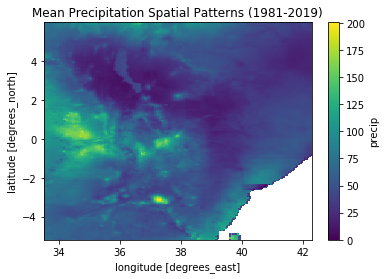

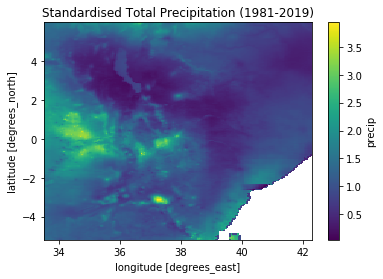

In [6]:
fig, ax = plt.subplots()
chirps.mean(dim='time').precip.plot(ax=ax, vmin=0)
ax.set_title('Mean Precipitation Spatial Patterns (1981-2019)');

# sum of precip is the same as the mean!
fig, ax = plt.subplots()
mask = chirps.isel(time=0).isnull()
(chirps.sum(dim='time').precip / chirps.sum(dim='time').mean()).where(~mask).precip.plot(ax=ax)
ax.set_title('Standardised Total Precipitation (1981-2019)');

### VHI

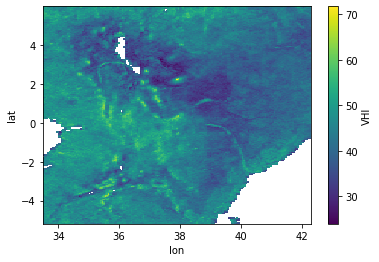

In [15]:
vhi.VHI.mean(dim='time').plot()

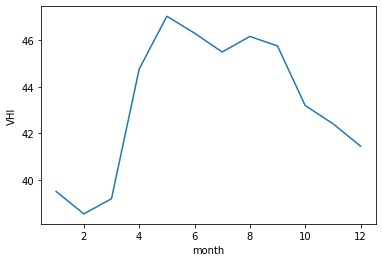

In [45]:
fig, ax = plt.subplots()
vhi.VHI.groupby('time.month').mean().plot(ax=ax)

mean_vhi = vhi.VHI.groupby('time.month').mean().to_dataframe()
std_vhi = vhi.VHI.groupby('time.month').std().to_dataframe()

In [53]:
mean_vhi = vhi.VHI.groupby('time.month').mean().to_dataframe()

climatology = mean_vhi.copy()
climatology['max_std'] = mean_vhi + std_vhi
climatology['min_std'] = mean_vhi - std_vhi

climatology.head()

VHI    max_std    min_std
month                                 
1      39.506511  61.610849  17.402174
2      38.543130  59.447191  17.639068
3      39.195995  59.567387  18.824602
4      44.761940  65.321257  24.202622
5      47.027994  67.342124  26.713865

In [31]:
d = vhi.VHI.mean(dim=['lat', 'lon'])
d['year'] = d['time.year']
d['month'] = d['time.month']
d = d.sel(time=slice('1982', '2018'))

df = d.to_dataframe()
display(df.head())
df.tail()

year  month        VHI
time                              
1982-01-31  1982      1  32.644745
1982-02-28  1982      2  31.239601
1982-03-31  1982      3  30.100931
1982-04-30  1982      4  45.182809
1982-05-31  1982      5  57.527845

year  month        VHI
time                              
2018-08-31  2018      8  54.338413
2018-09-30  2018      9  52.480346
2018-10-31  2018     10  44.597653
2018-11-30  2018     11  38.613651
2018-12-31  2018     12  36.903491

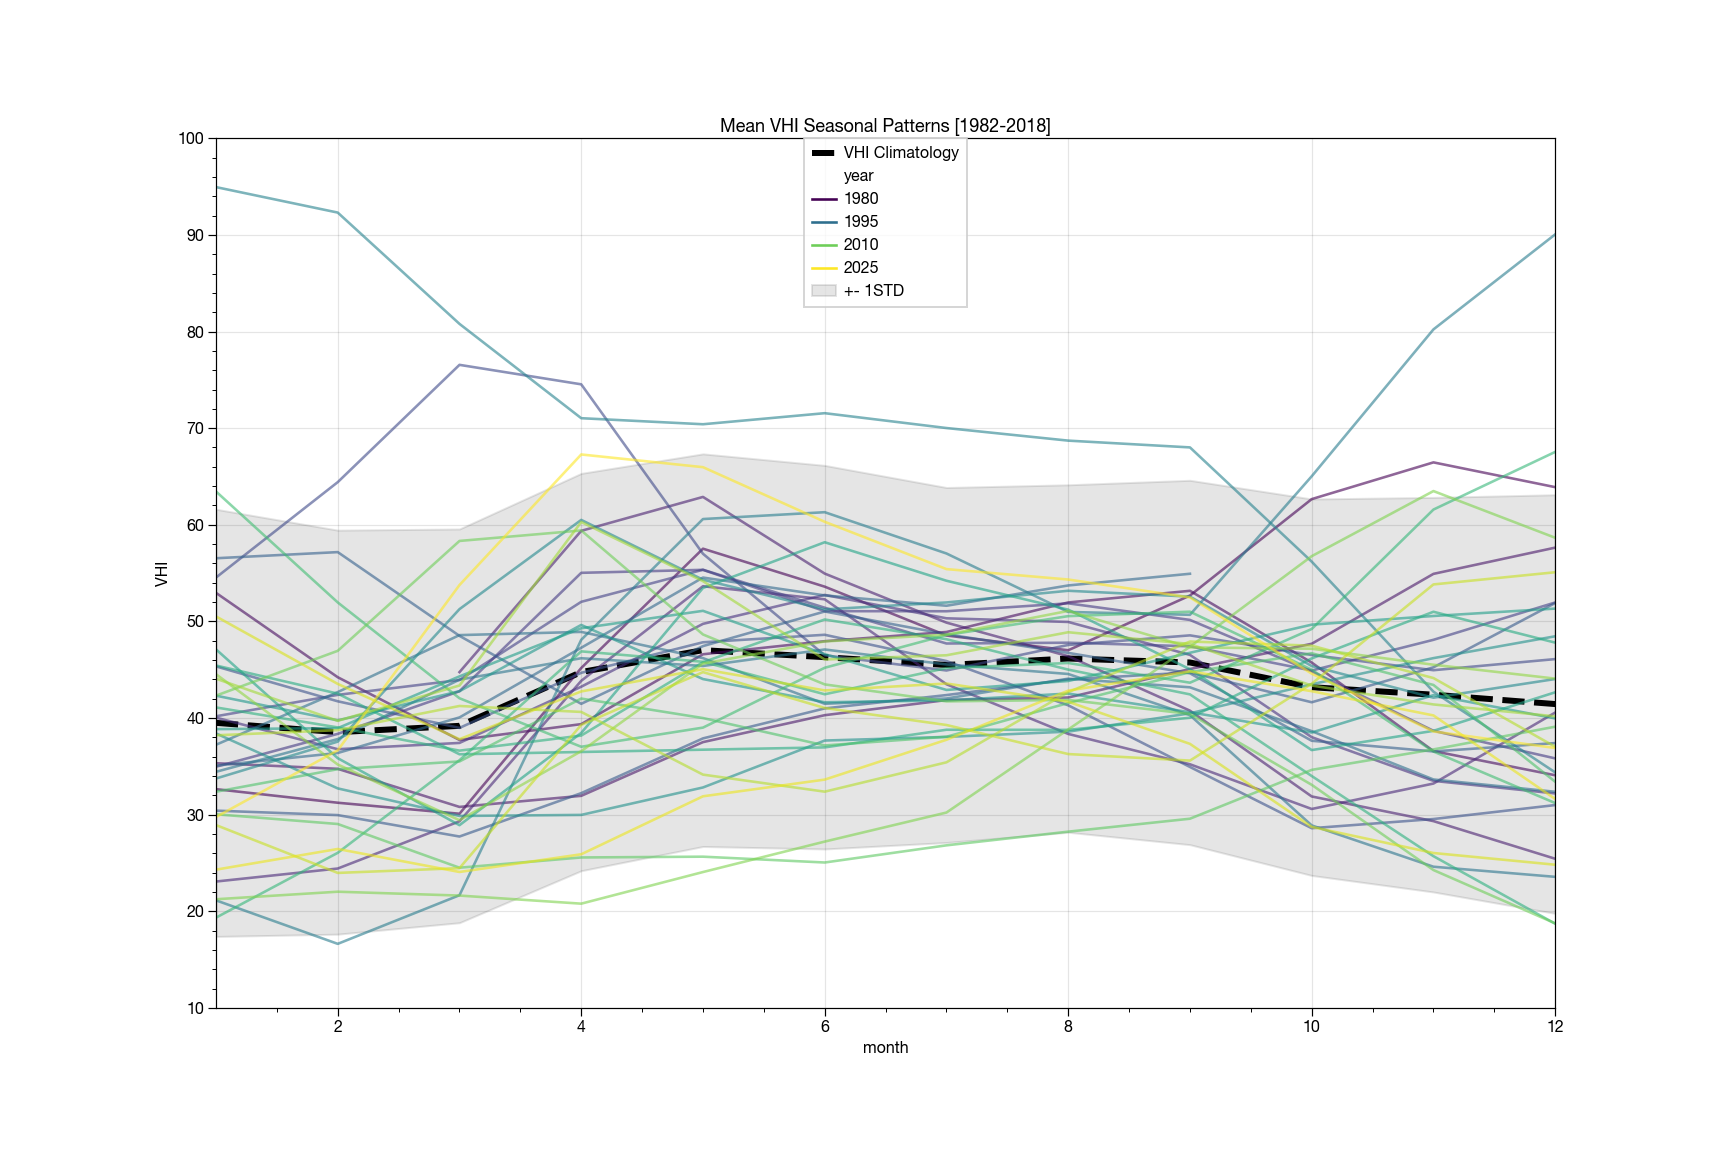

In [77]:
# NOTE: really need a tooltip to hover over the patterns to view which line corresponds to which year
fig, ax = plt.subplots(figsize=(12, 8))

mean_vhi.rename(columns={'VHI': 'VHI Climatology'}).plot(ax=ax, color='black', lw=3, ls='--')
ax.fill_between(climatology.index, climatology.min_std, climatology.max_std, alpha=0.1, color='black', label='+- 1STD');
sns.lineplot(x="month", y="VHI", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')

ax.set_ylim([10, 100])
ax.set_title('VHI Seasonal Patterns [1982-2018]');

In [67]:
# using proplot https://proplot.readthedocs.io/en/latest/quickstart1.html
import proplot as plot

import calendar

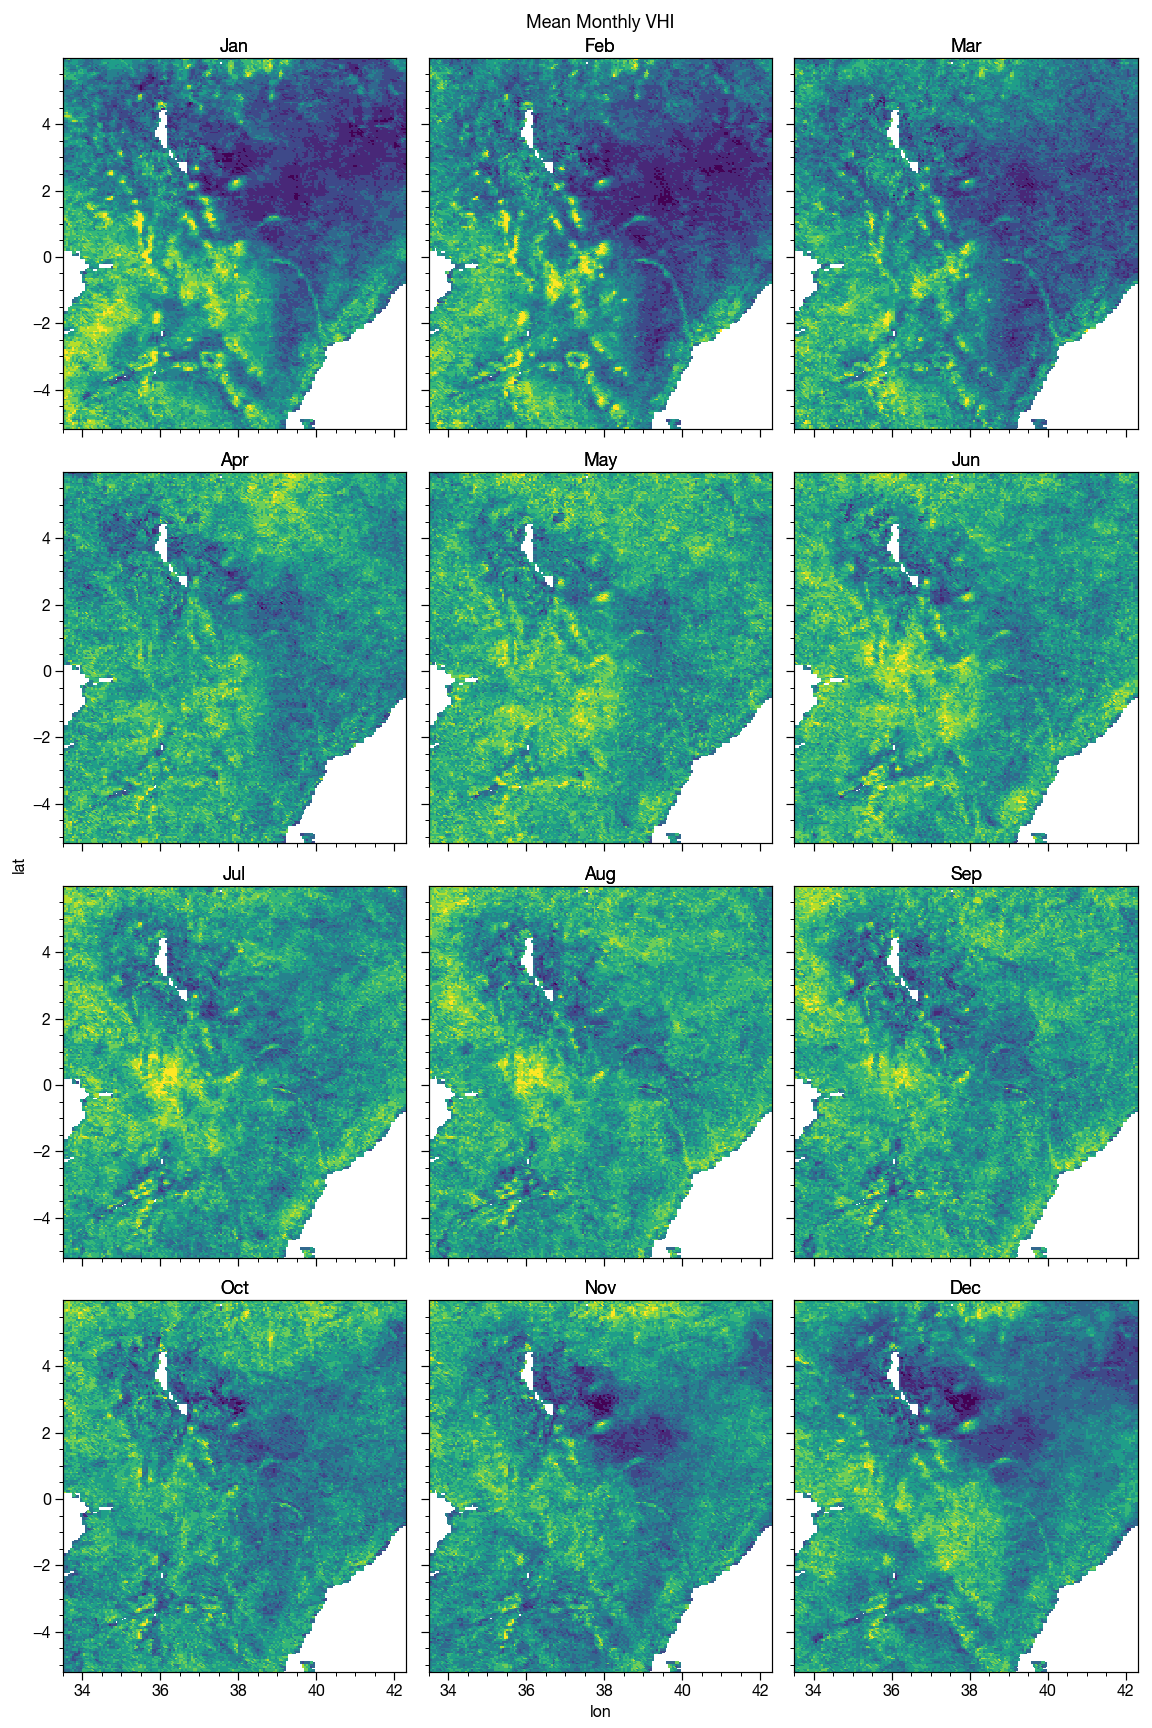

In [124]:
f, axs = plot.subplots(nrows=4, ncols=3, share=3, span=1, axwidth=1.5, figsize=(8,12))
axs.format(
    xlabel='longitude', ylabel='latitude', suptitle='Mean Monthly VHI', abc=0, abcloc='ul', 
)

month_abbrs = [m for m in calendar.month_abbr if m != '']
mean_vhi = vhi.VHI.groupby('time.month').mean(dim='time')
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    mean_vhi.sel(month=mth).plot(ax=ax, vmin=15, vmax=70, add_colorbar=False, cmap='viridis')
    ax.set_title(month_abbrs[mth - 1])

### CHIRPS

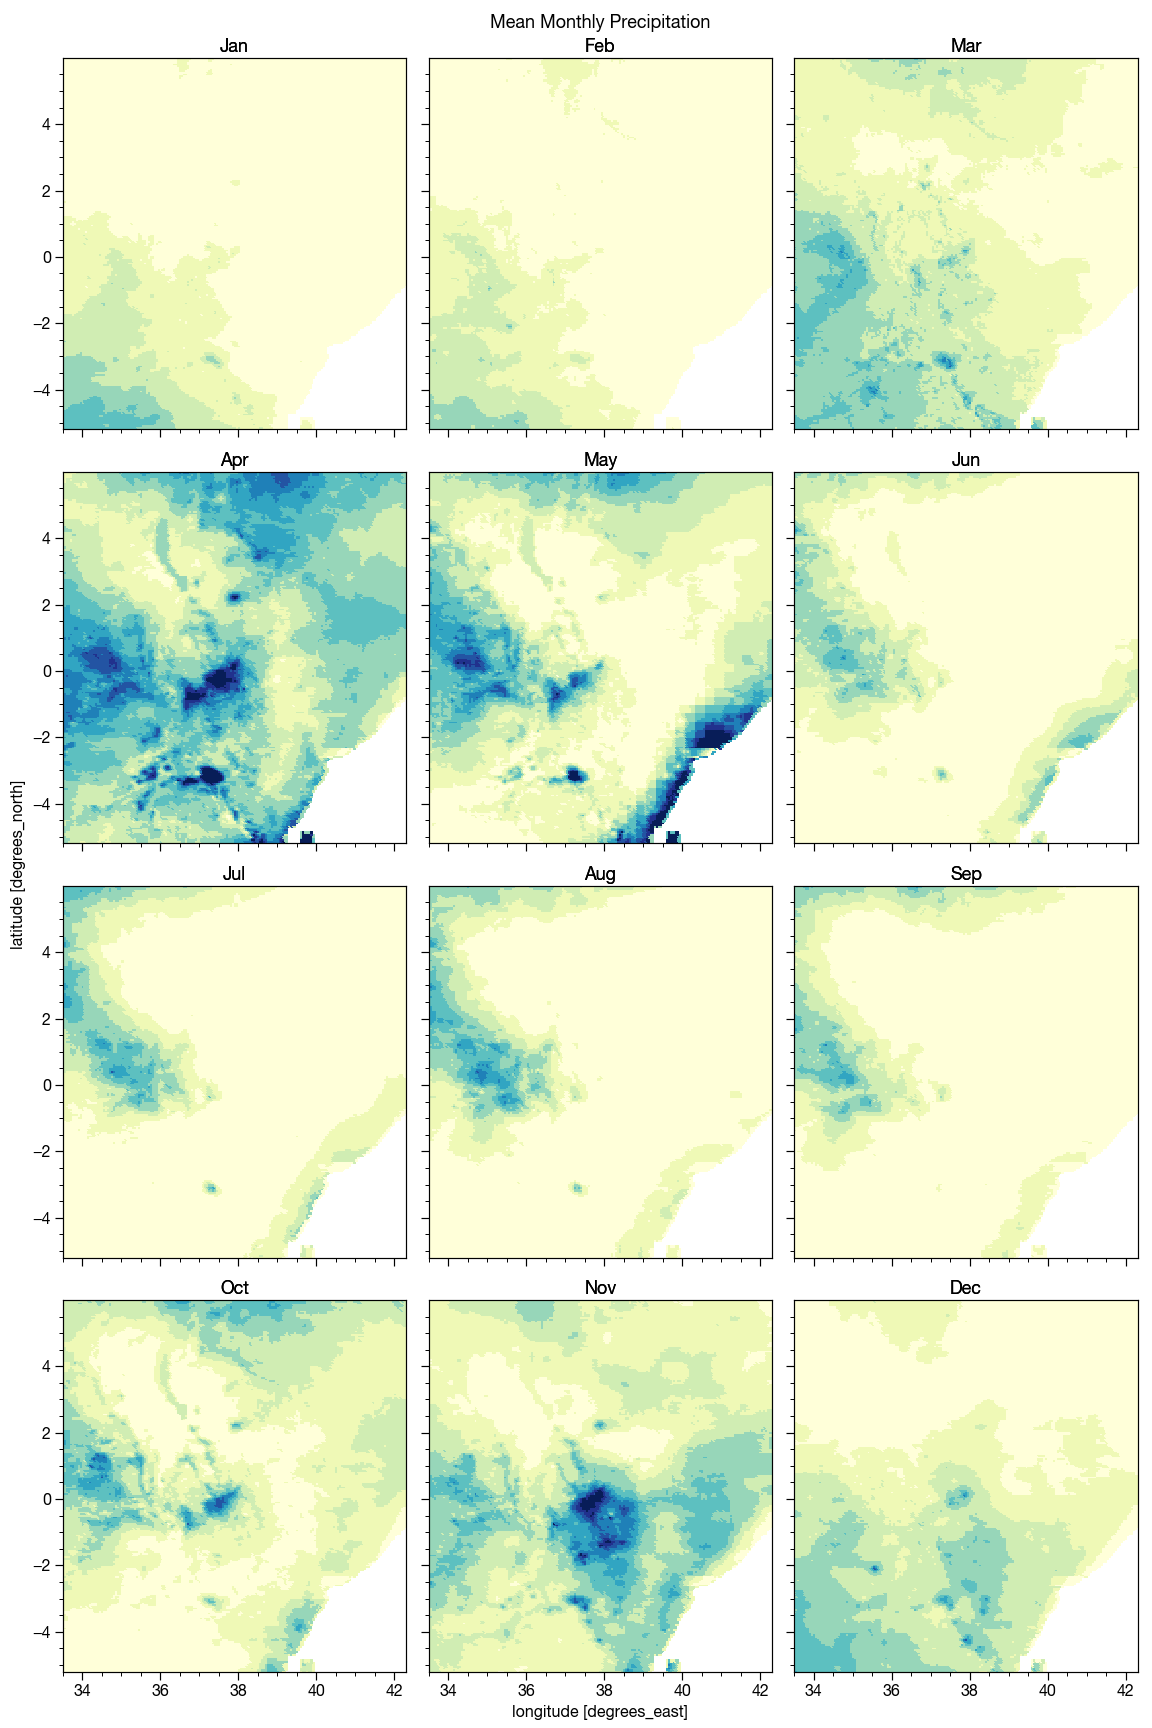

In [114]:
f, axs = plot.subplots(nrows=4, ncols=3, share=3, span=1, axwidth=1.5, figsize=(8,12))
axs.format(
    xlabel='longitude', ylabel='latitude', suptitle='Mean Monthly Precipitation', abc=0, abcloc='ul', 
)

month_abbrs = [m for m in calendar.month_abbr if m != '']
mean_precip = chirps.precip.groupby('time.month').mean(dim='time')
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    mean_precip.sel(month=mth).plot(ax=ax, vmin=0, vmax=350, add_colorbar=False, cmap='YlGnBu')
    ax.set_title(month_abbrs[mth - 1])

In [138]:
# dataframe of climatology
mean_precip = chirps.precip.groupby('time.month').mean().to_dataframe()
std_precip = chirps.precip.groupby('time.month').std().to_dataframe()

climatology = mean_precip.copy()
climatology['max_std'] = mean_precip + std_precip
climatology['min_std'] = mean_precip - std_precip
climatology['min_std'].loc[climatology['min_std'] < 0] = 0

display(climatology.head())

# build dataframe of values each year
d = chirps.precip.mean(dim=['lat', 'lon'])
d['year'] = d['time.year']
d['month'] = d['time.month']
d = d.sel(time=slice('1982', '2018'))

df = d.to_dataframe()
display(df.head())
df.tail()

precip     max_std   min_std
month                                  
1       29.301771   71.619646   0.00000
2       27.340691   62.223679   0.00000
3       69.533417  127.602783  11.46405
4      131.498428  212.290657  50.70620
5       78.399796  157.734566   0.00000

year  month      precip
time                               
1982-01-31  1982      1   19.896742
1982-02-28  1982      2   23.975689
1982-03-31  1982      3   42.290573
1982-04-30  1982      4  143.819809
1982-05-31  1982      5  111.322403

year  month      precip
time                               
2018-08-31  2018      8   33.054981
2018-09-30  2018      9   22.960476
2018-10-31  2018     10   58.119877
2018-11-30  2018     11   54.200142
2018-12-31  2018     12  104.412910

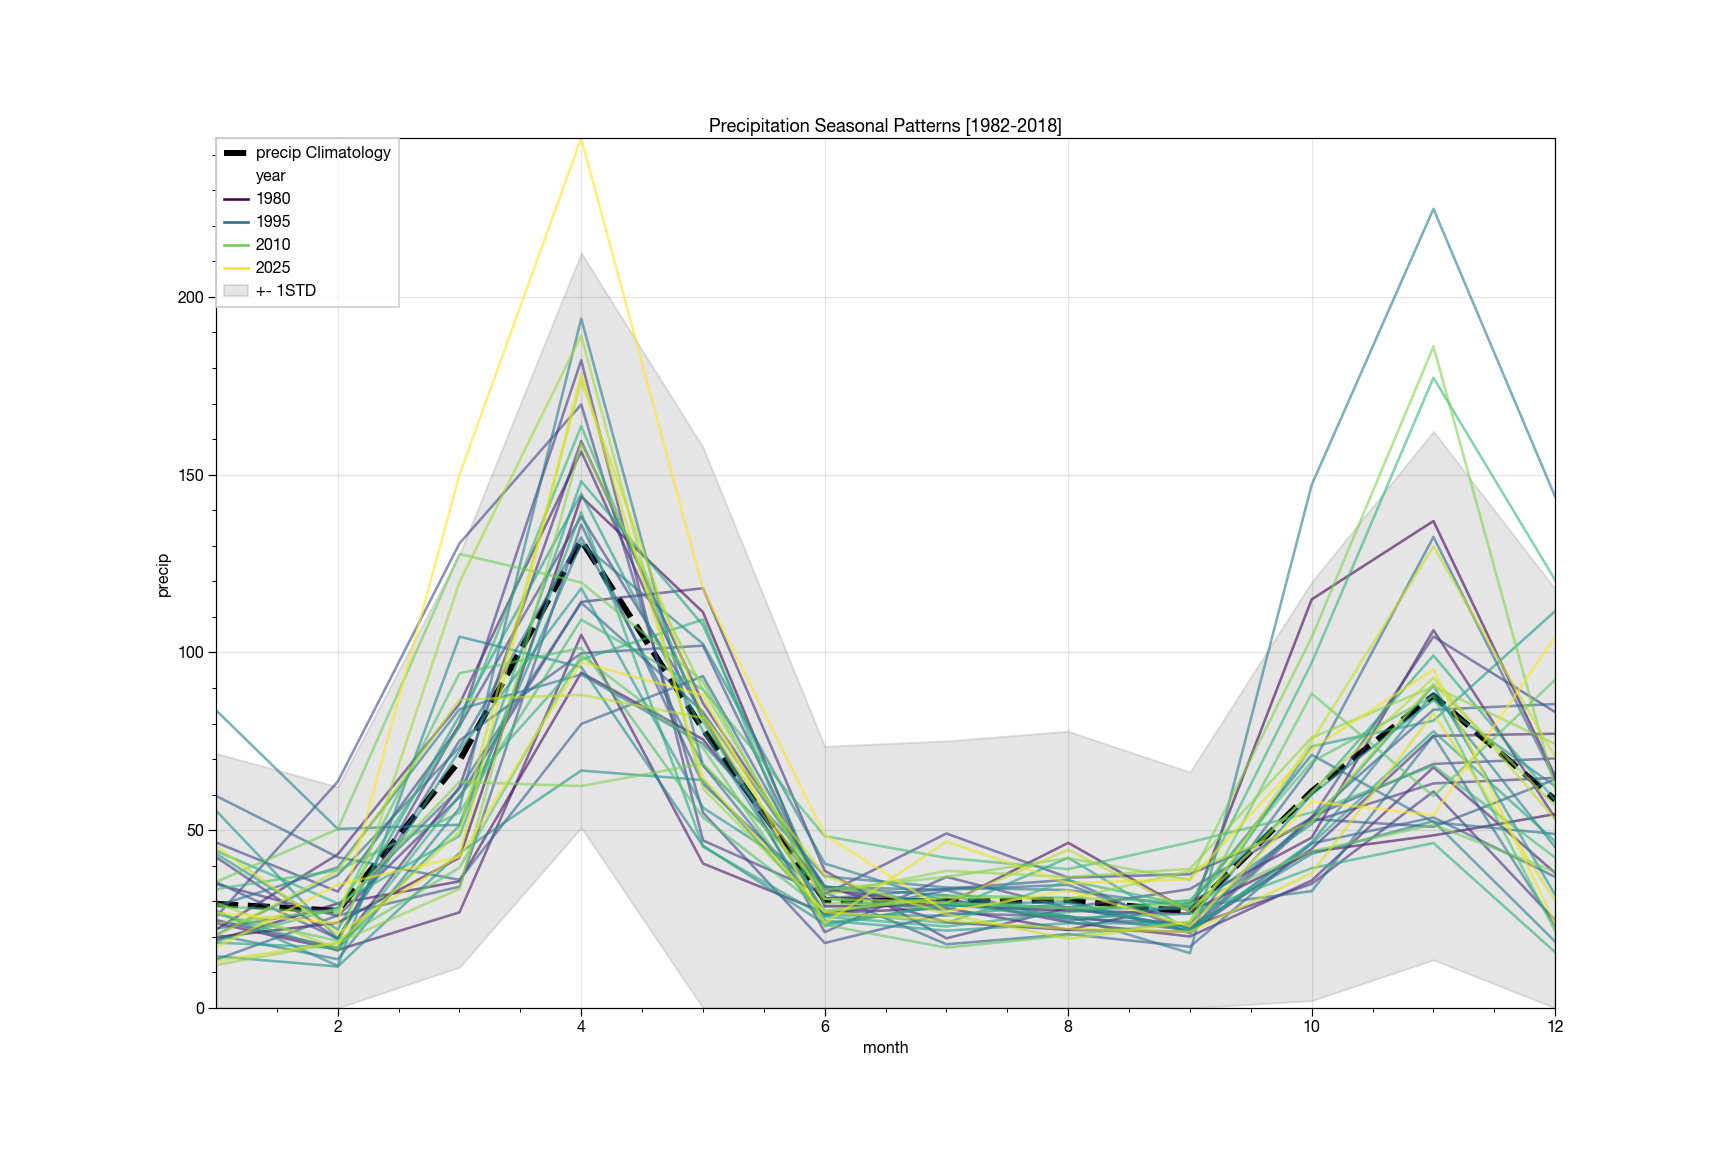

In [141]:
# NOTE: really need a tooltip to hover over the patterns to view which line corresponds to which year
fig, ax = plt.subplots(figsize=(12, 8))

mean_precip.rename(columns={'precip': 'precip Climatology'}).plot(ax=ax, color='black', lw=3, ls='--')
ax.fill_between(climatology.index, climatology.min_std, climatology.max_std, alpha=0.1, color='black', label='+- 1STD');
sns.lineplot(x="month", y="precip", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')

ax.set_title('Precipitation Seasonal Patterns [1982-2018]');

fig.savefig(plot_dir / 'precip_seasonal_patterns.png', dpi=300)

### GLEAM

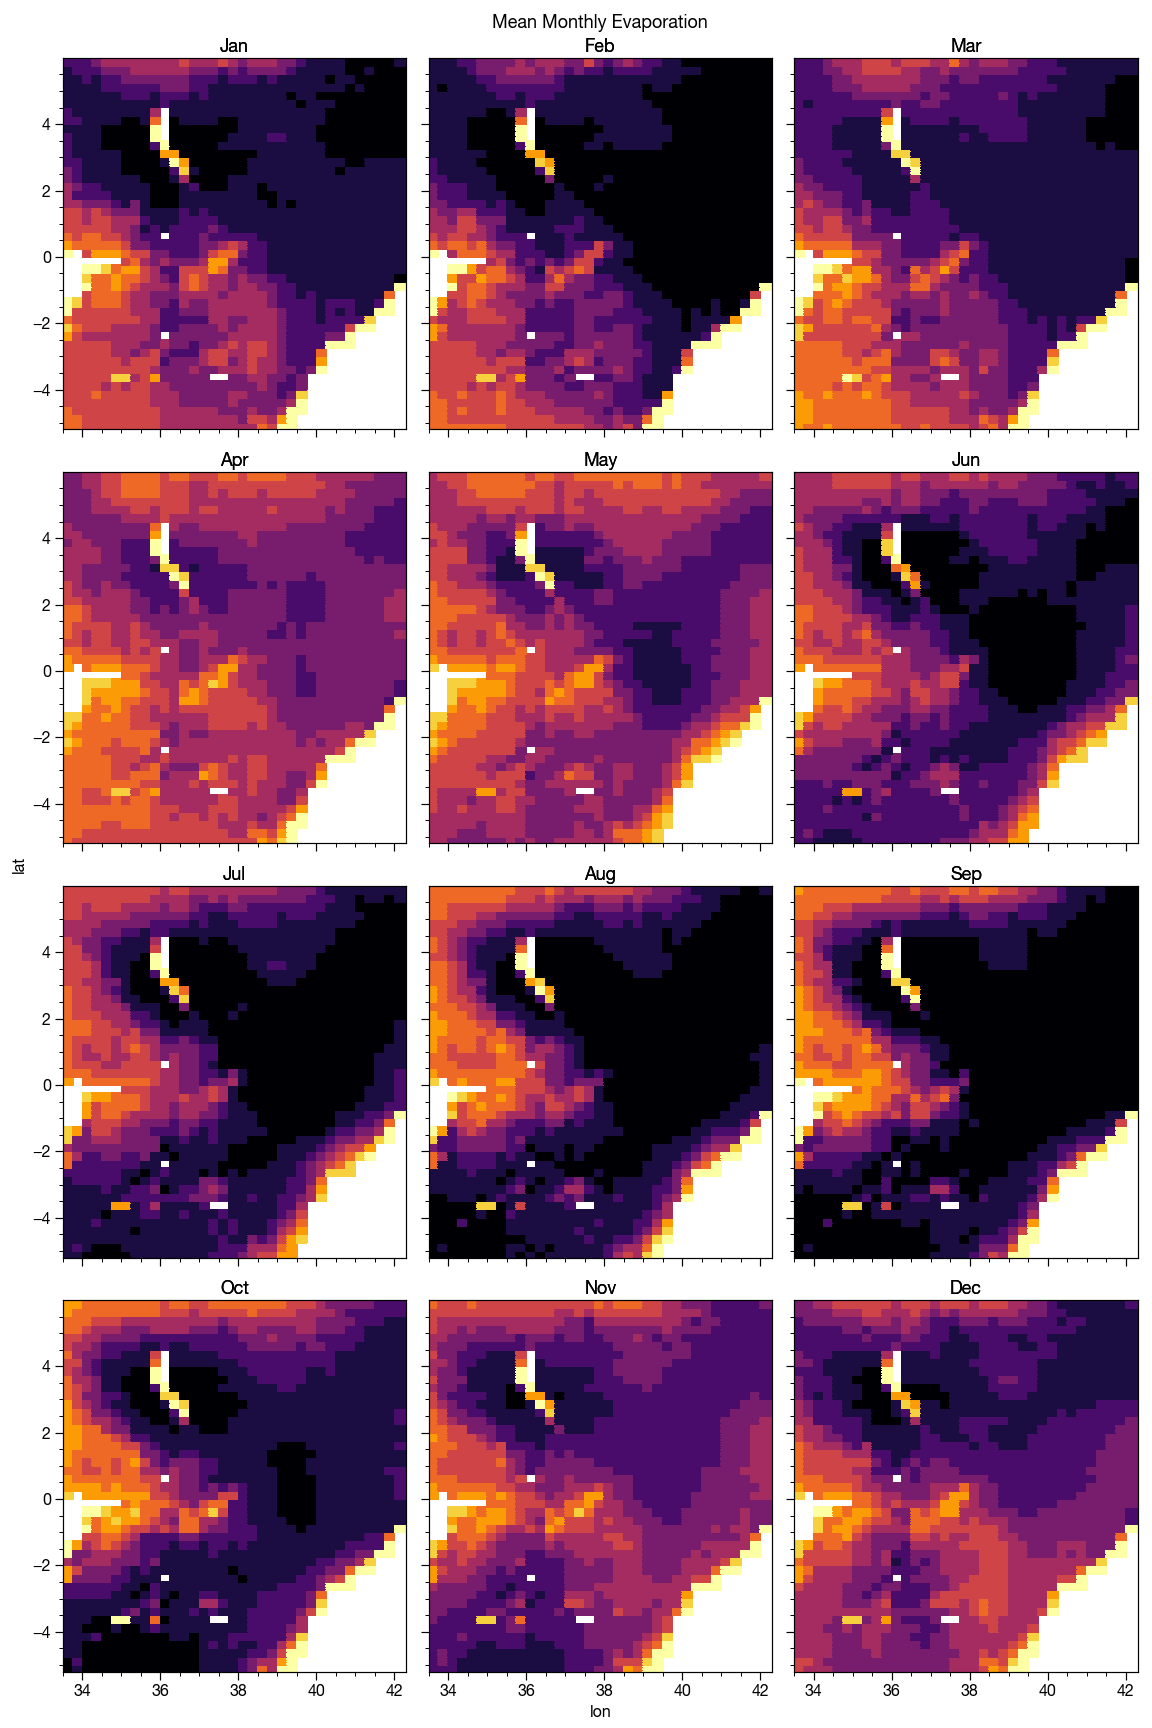

In [152]:
f, axs = plot.subplots(nrows=4, ncols=3, share=3, span=1, axwidth=1.5, figsize=(8,12))
axs.format(
    xlabel='longitude', ylabel='latitude', suptitle='Mean Monthly Evaporation', abc=0, abcloc='ul', 
)

month_abbrs = [m for m in calendar.month_abbr if m != '']
mean_evap = gleam.E.groupby('time.month').mean(dim='time')
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    mean_evap.sel(month=mth).plot(ax=ax, vmin=0, vmax=150, add_colorbar=False, cmap='inferno')
    ax.set_title(month_abbrs[mth - 1])

precip    max_std    min_std
month                                  
1       29.301771  80.945781   6.924645
2       27.340691  72.665291   0.360896
3       69.533417  87.111840  10.199259
4      131.498428  95.357347  40.866974
5       78.399796  93.164497  36.655471

year  month          E
time                              
1982-01-31  1982      1  28.793423
1982-02-28  1982      2  26.763839
1982-03-31  1982      3  30.727309
1982-04-30  1982      4  71.256074
1982-05-31  1982      5  70.950287

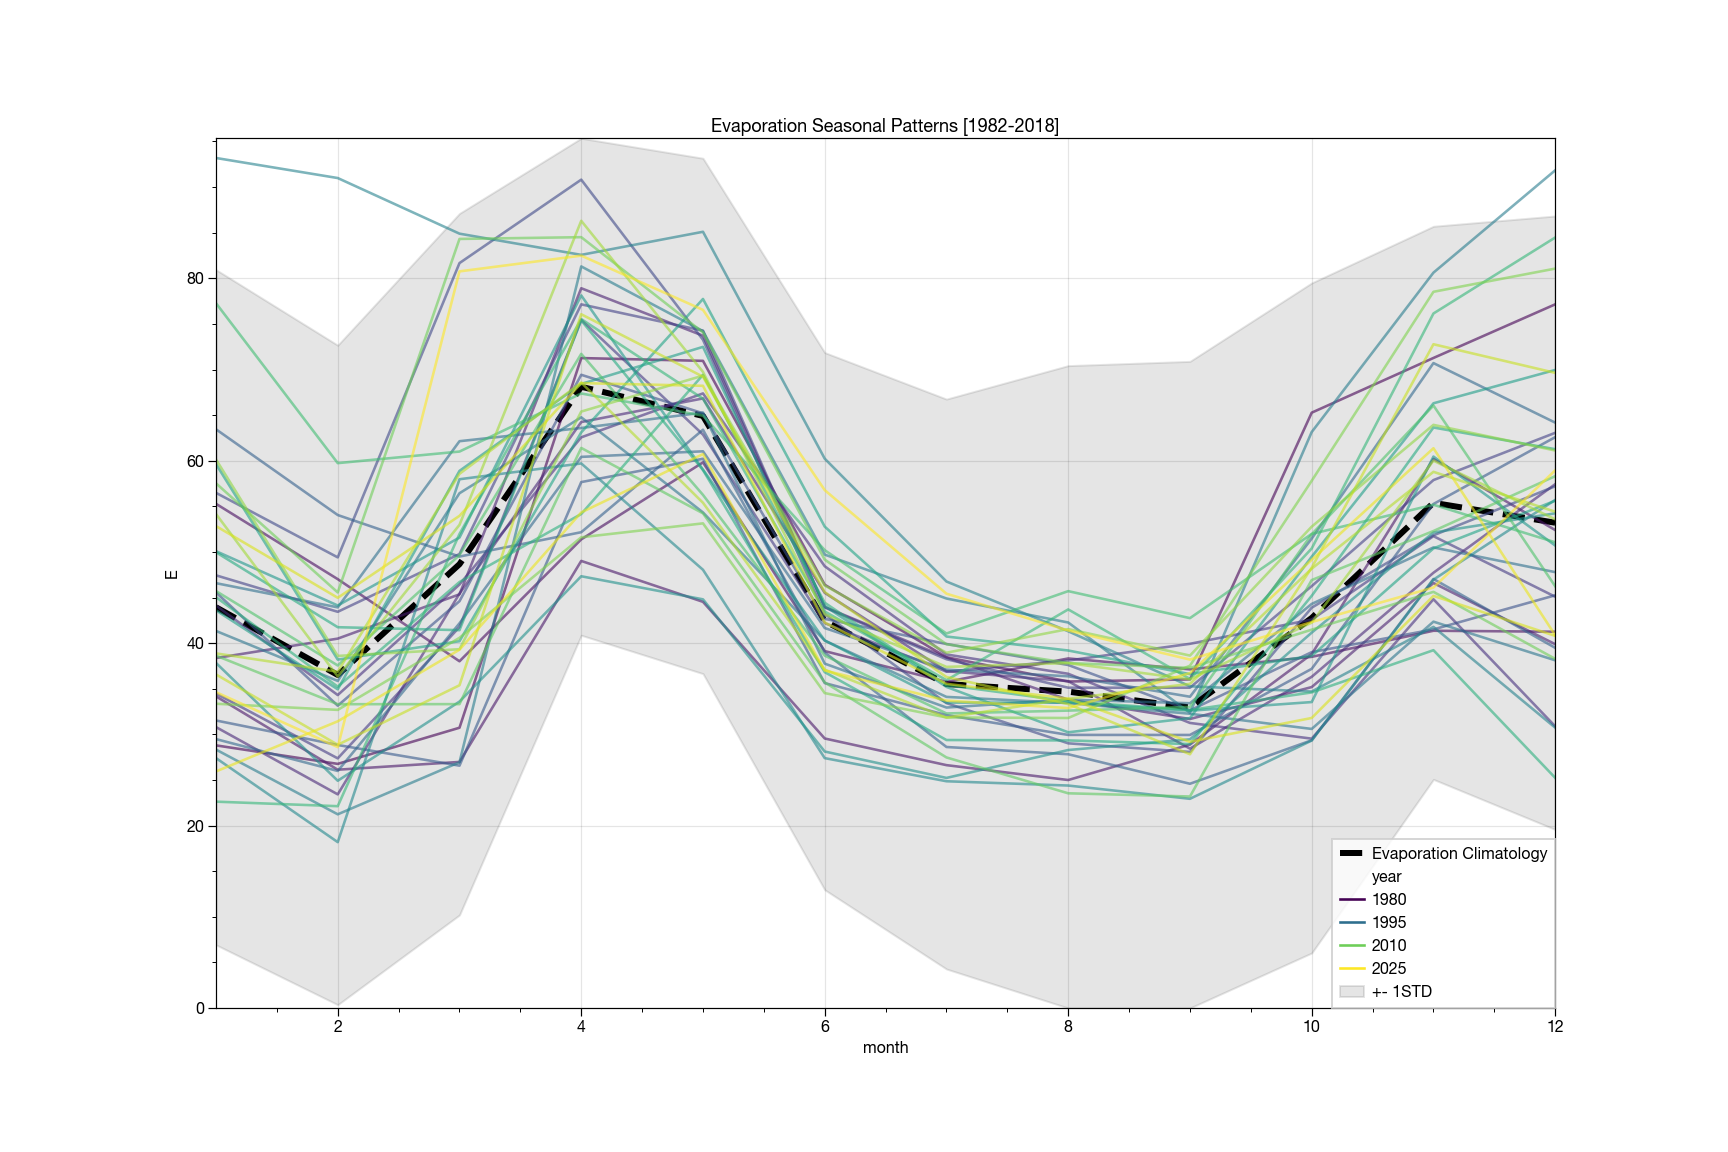

In [154]:
# dataframe of climatology
mean_evap = gleam.E.groupby('time.month').mean().to_dataframe()
std_evap = gleam.E.groupby('time.month').std().to_dataframe()

climatology = mean_precip.copy()
climatology['max_std'] = mean_evap + std_evap
climatology['min_std'] = mean_evap - std_evap
climatology['min_std'].loc[climatology['min_std'] < 0] = 0

display(climatology.head())

# build dataframe of values each year
d = gleam.E.mean(dim=['lat', 'lon'])
d['year'] = d['time.year']
d['month'] = d['time.month']
d = d.sel(time=slice('1982', '2018'))

df = d.to_dataframe()
display(df.head())
df.tail()

# NOTE: really need a tooltip to hover over the patterns to view which line corresponds to which year
fig, ax = plt.subplots(figsize=(12, 8))

mean_evap.rename(columns={'E': 'Evaporation Climatology'}).plot(ax=ax, color='black', lw=3, ls='--')
ax.fill_between(climatology.index, climatology.min_std, climatology.max_std, alpha=0.1, color='black', label='+- 1STD');
sns.lineplot(x="month", y="E", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')

ax.set_title('Evaporation Seasonal Patterns [1982-2018]');

fig.savefig(plot_dir / 'evap_seasonal_patterns.png', dpi=300)

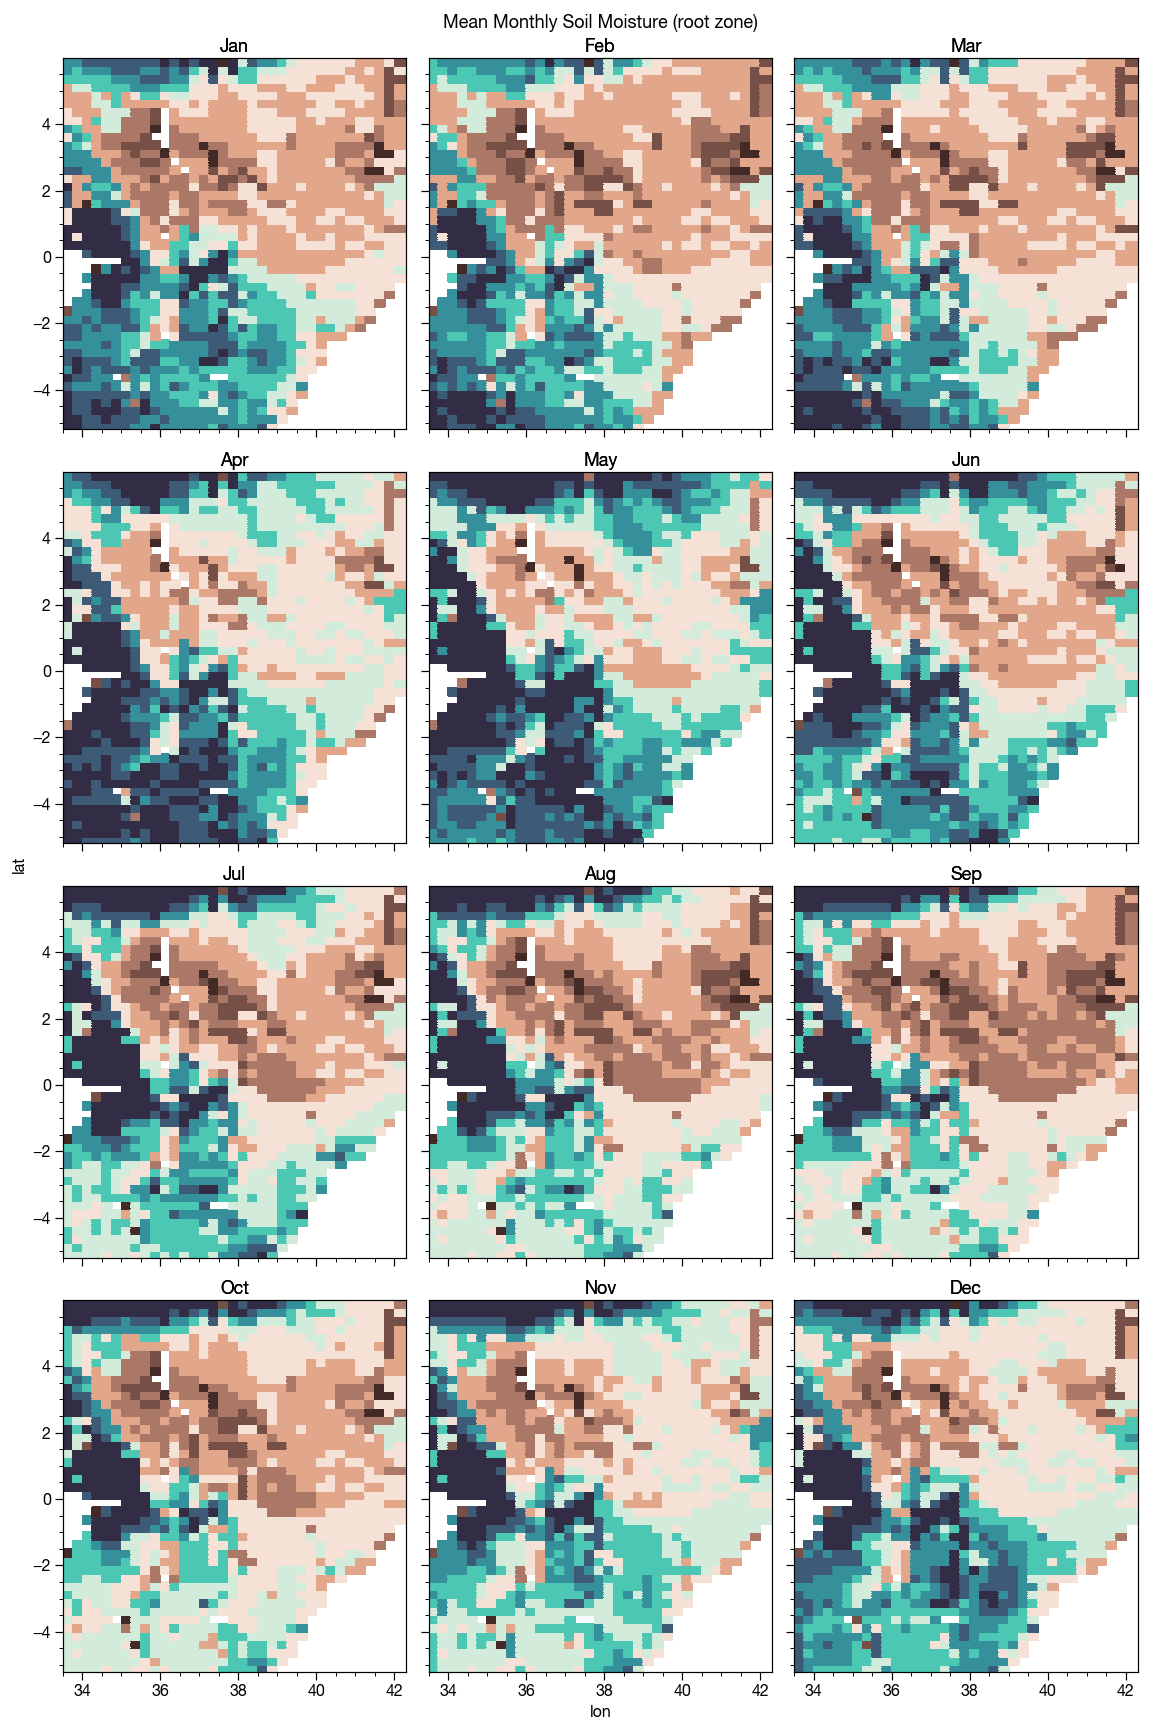

In [161]:
f, axs = plot.subplots(nrows=4, ncols=3, share=3, span=1, axwidth=1.5, figsize=(8,12))
axs.format(
    xlabel='longitude', ylabel='latitude', suptitle='Mean Monthly Soil Moisture (root zone)', abc=0, abcloc='ul', 
)

month_abbrs = [m for m in calendar.month_abbr if m != '']
mean_sm = gleam.SMroot.groupby('time.month').mean(dim='time')
for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    mean_sm.sel(month=mth).plot(ax=ax, vmin=0.05, vmax=0.35, add_colorbar=False, cmap='moisture')
    ax.set_title(month_abbrs[mth - 1])

SMroot   max_std   min_std
month                              
1      0.212740  0.291705  0.133776
2      0.200972  0.275117  0.126827
3      0.206089  0.281402  0.130776
4      0.239595  0.319943  0.159247
5      0.255109  0.339765  0.170453

year  month    SMroot
time                             
1982-01-31  1982      1  0.189128
1982-02-28  1982      2  0.185830
1982-03-31  1982      3  0.183628
1982-04-30  1982      4  0.230227
1982-05-31  1982      5  0.271377

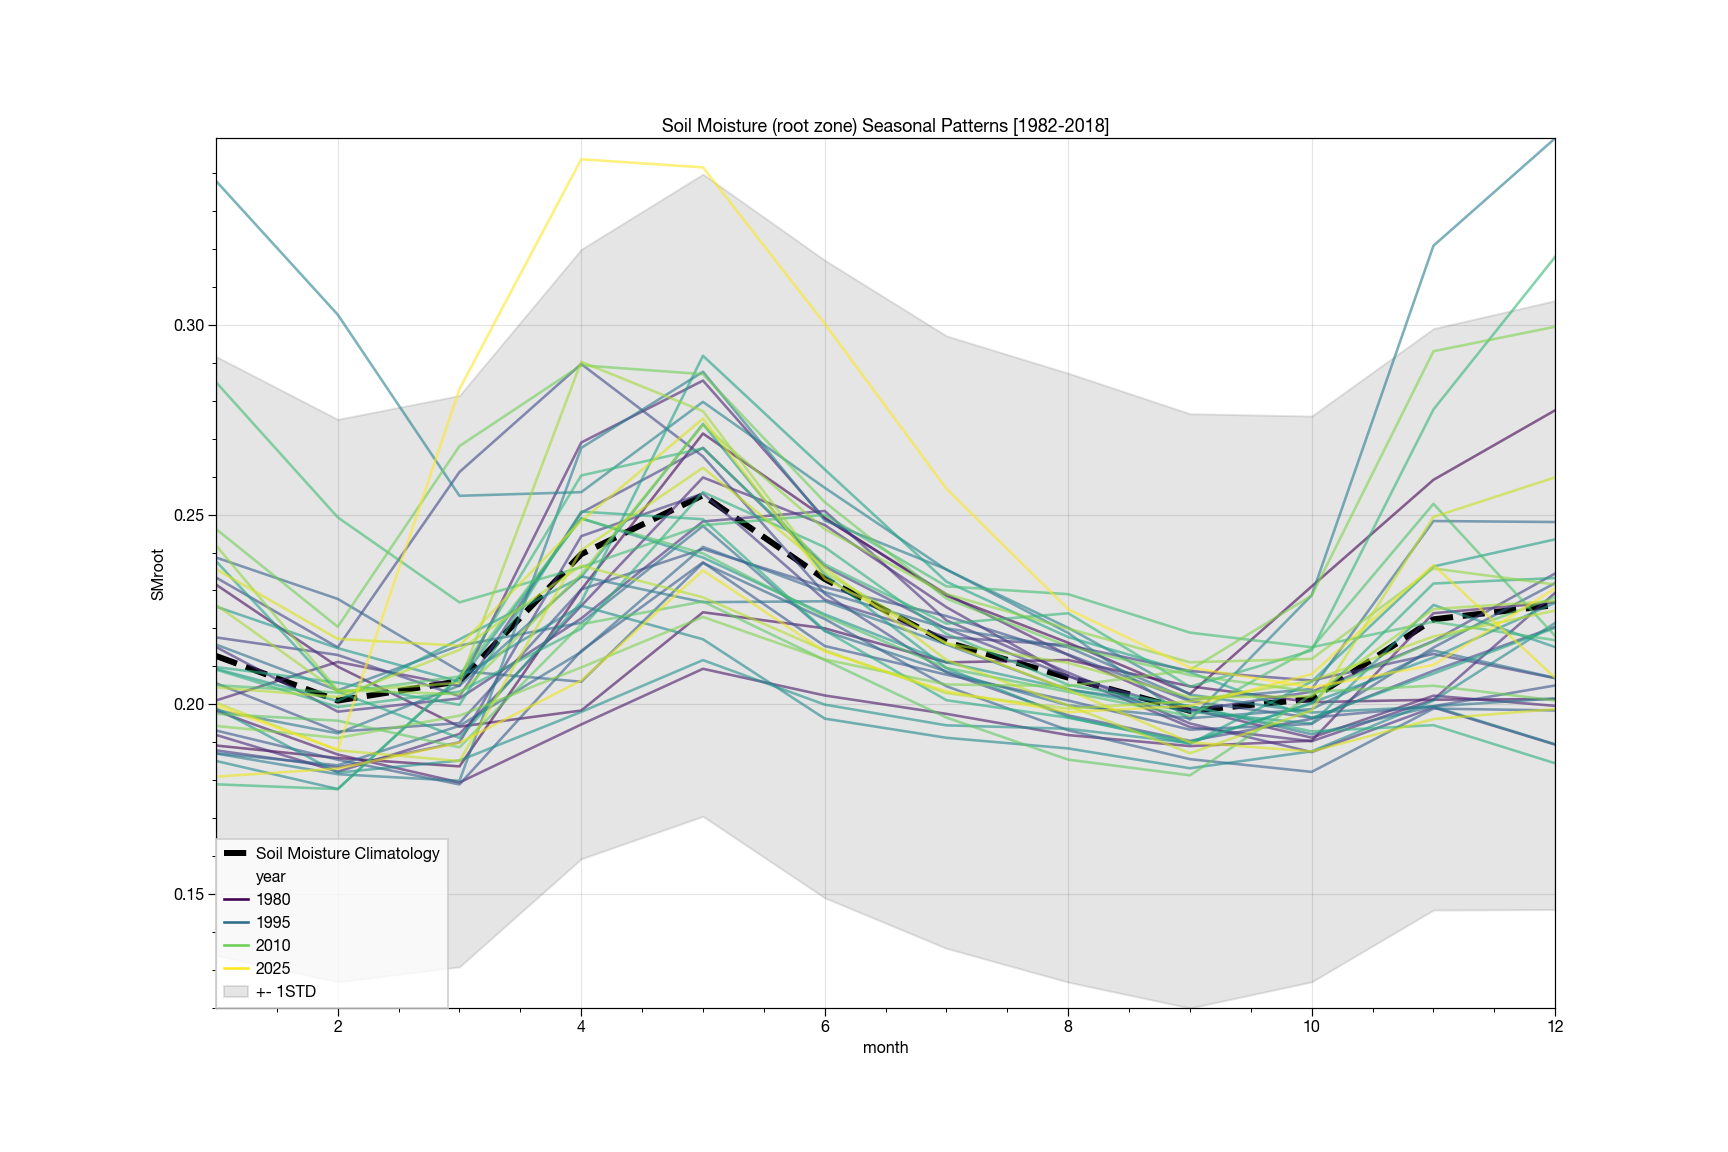

In [158]:
# dataframe of climatology
mean_sm = gleam.SMroot.groupby('time.month').mean().to_dataframe()
std_sm = gleam.SMroot.groupby('time.month').std().to_dataframe()

climatology = mean_sm.copy()
climatology['max_std'] = mean_sm + std_sm
climatology['min_std'] = mean_sm - std_sm
climatology['min_std'].loc[climatology['min_std'] < 0] = 0

display(climatology.head())

# build dataframe of values each year
d = gleam.SMroot.mean(dim=['lat', 'lon'])
d['year'] = d['time.year']
d['month'] = d['time.month']
d = d.sel(time=slice('1982', '2018'))

df = d.to_dataframe()
display(df.head())
df.tail()

# NOTE: really need a tooltip to hover over the patterns to view which line corresponds to which year
fig, ax = plt.subplots(figsize=(12, 8))

mean_sm.rename(columns={'SMroot': 'Soil Moisture Climatology'}).plot(ax=ax, color='black', lw=3, ls='--')
ax.fill_between(climatology.index, climatology.min_std, climatology.max_std, alpha=0.1, color='black', label='+- 1STD');
sns.lineplot(x="month", y="SMroot", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')

ax.set_title('Soil Moisture (root zone) Seasonal Patterns [1982-2018]');

fig.savefig(plot_dir / 'soil_moisture_seasonal_patterns.png', dpi=300)

### ERA5

In [173]:
if 'air_temperature_at_2_metres' in list(era5.data_vars):
    era5 = era5.rename({'air_temperature_at_2_metres': 'temp'})
era5

<xarray.Dataset>
Dimensions:                                    (lat: 224, lon: 176, time: 133)
Coordinates:
  * time                                       (time) datetime64[ns] 2008-01-31 ... 2019-01-31
  * lon                                        (lon) float32 33.524994 ... 42.274994
  * lat                                        (lat) float32 -5.175003 ... 5.9749985
Data variables:
    temp                                       (time, lat, lon) float64 ...
    air_temperature_at_2_metres_1hour_Maximum  (time, lat, lon) float64 ...
    precipitation_amount_1hour_Accumulation    (time, lat, lon) float64 ...

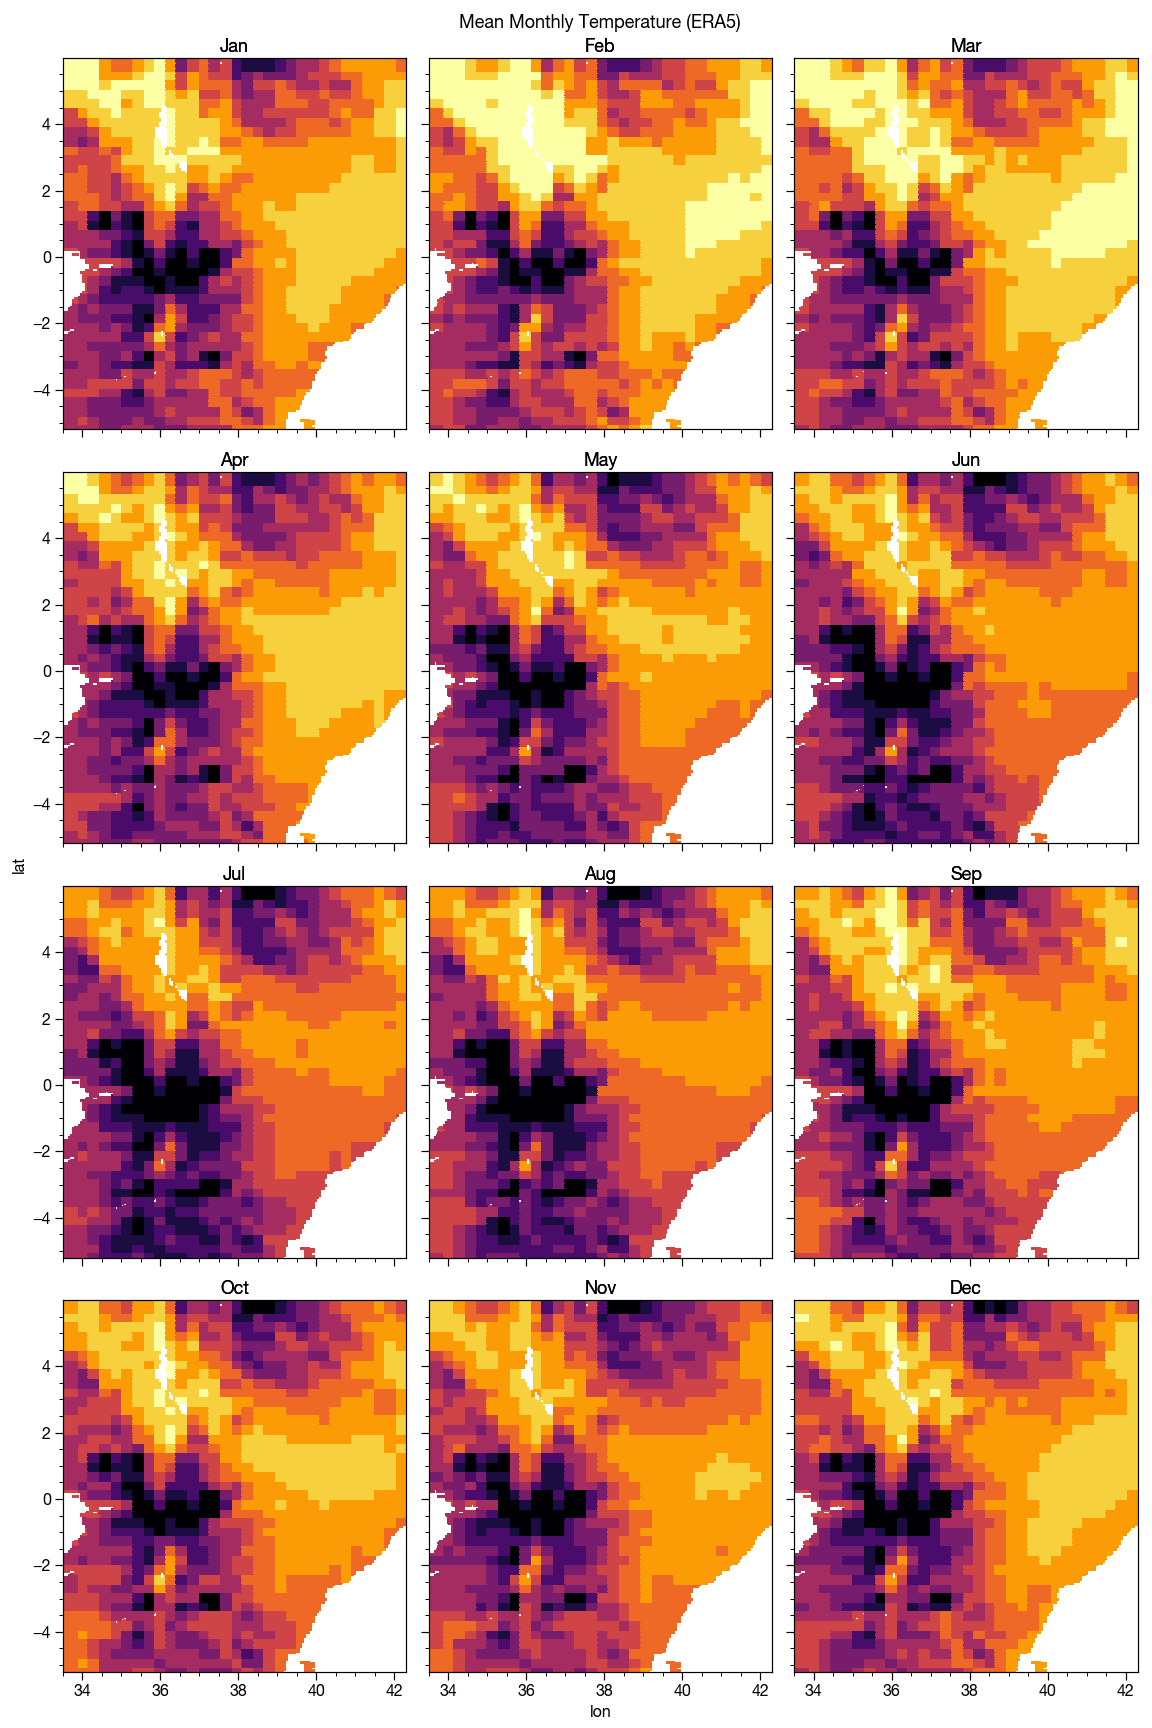

In [183]:
f, axs = plot.subplots(nrows=4, ncols=3, share=3, span=1, axwidth=1.5, figsize=(8,12))
axs.format(
    xlabel='longitude', ylabel='latitude', suptitle='Mean Monthly Temperature (ERA5)', abc=0, abcloc='ul', 
)

month_abbrs = [m for m in calendar.month_abbr if m != '']
mask = vhi.VHI.isel(time=0).isnull()
mean_temp = era5.temp.groupby('time.month').mean(dim='time').where(~mask)

for mth in np.arange(1, 13):
    ax = axs[mth - 1]
    mean_temp.sel(month=mth).plot(ax=ax, vmin=288, vmax=305, add_colorbar=False, cmap='inferno')
    ax.set_title(month_abbrs[mth - 1])

temp     max_std     min_std
month                                    
1      298.522620  302.410553  294.634687
2      299.452887  303.240855  295.664919
3      299.359709  303.232098  295.487320
4      298.164952  302.029124  294.300780
5      297.567748  301.383174  293.752322

year  month        temp
time                               
2008-01-31  2008      1  298.452156
2008-02-29  2008      2  298.870171
2008-03-31  2008      3  298.797282
2008-04-30  2008      4  297.493712
2008-05-31  2008      5  297.573462

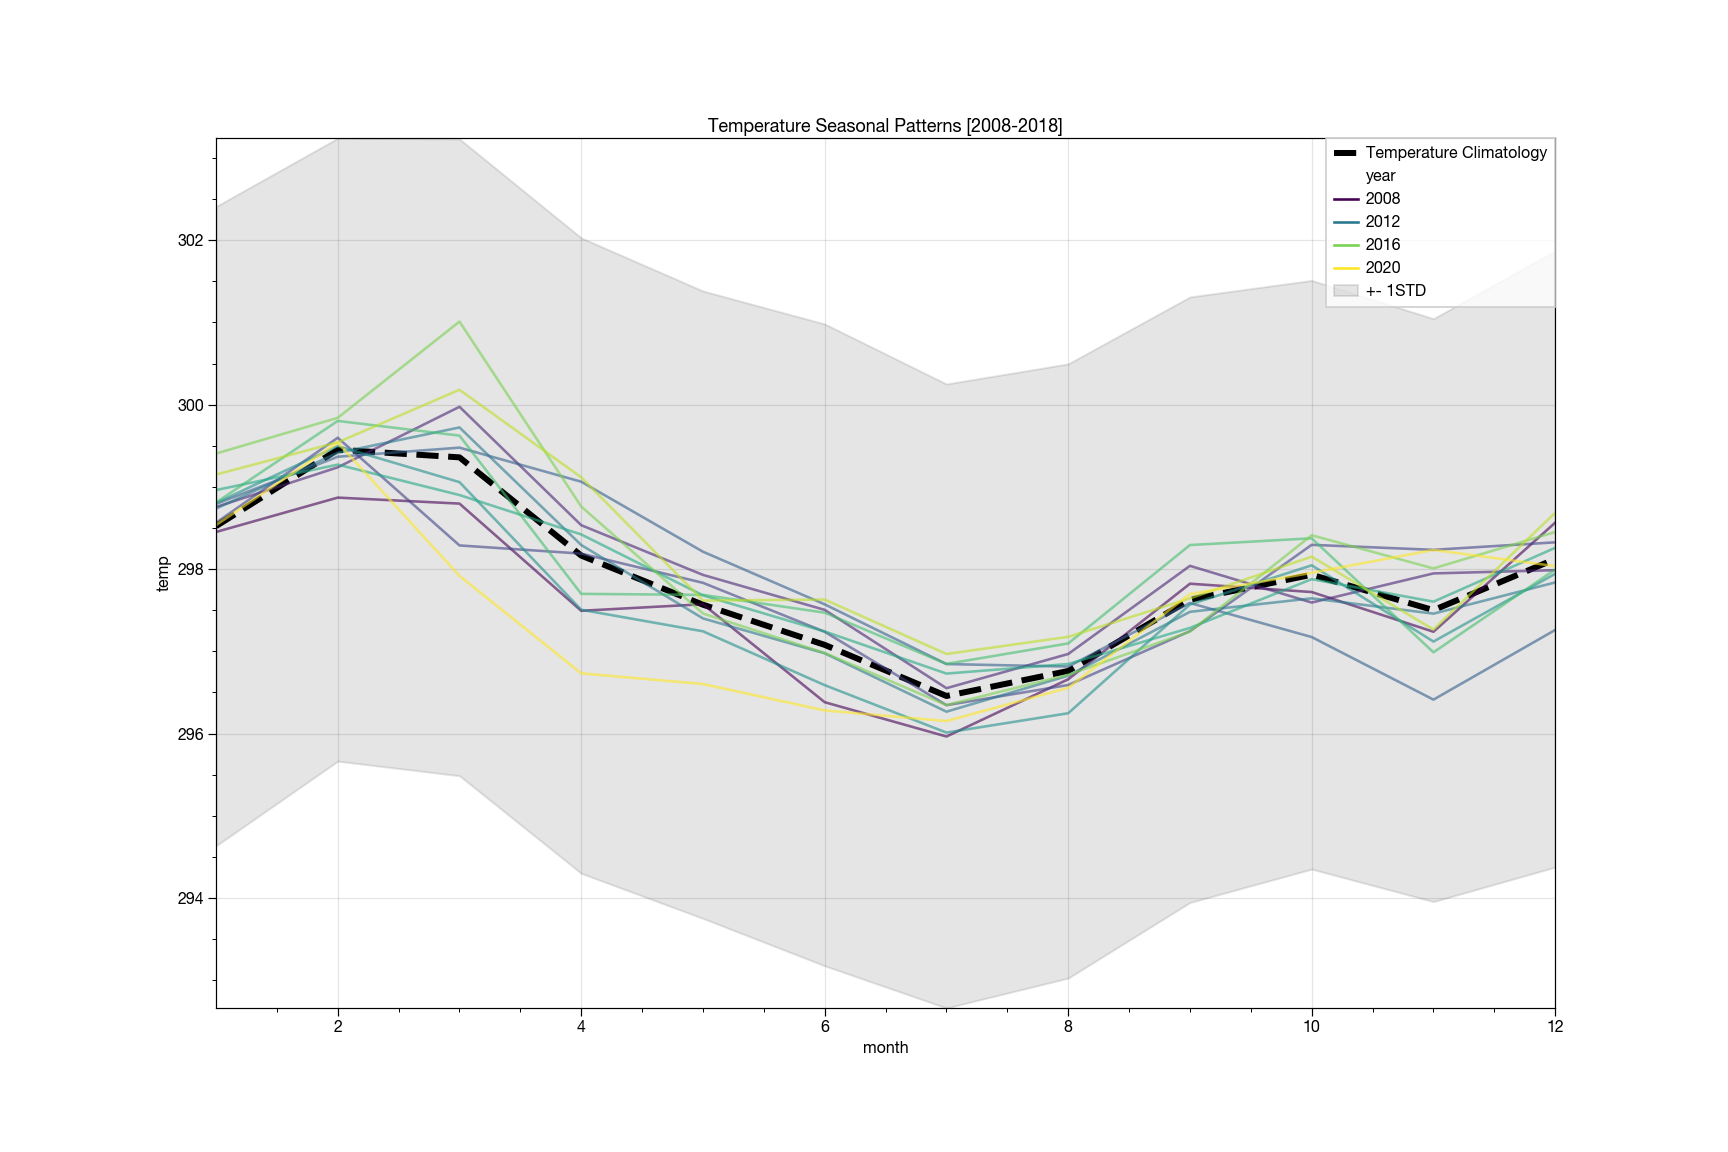

In [176]:
# dataframe of climatology
mean_temp = era5.temp.groupby('time.month').mean().to_dataframe()
std_temp = era5.temp.groupby('time.month').std().to_dataframe()

climatology = mean_temp.copy()
climatology['max_std'] = mean_temp + std_temp
climatology['min_std'] = mean_temp - std_temp
climatology['min_std'].loc[climatology['min_std'] < 0] = 0

display(climatology.head())

# build dataframe of values each year
d = era5.temp.mean(dim=['lat', 'lon'])
d['year'] = d['time.year']
d['month'] = d['time.month']
d = d.sel(time=slice('1982', '2018'))

df = d.to_dataframe()
display(df.head())
df.tail()

# NOTE: really need a tooltip to hover over the patterns to view which line corresponds to which year
fig, ax = plt.subplots(figsize=(12, 8))

mean_temp.rename(columns={'temp': 'Temperature Climatology'}).plot(ax=ax, color='black', lw=3, ls='--')
ax.fill_between(climatology.index, climatology.min_std, climatology.max_std, alpha=0.1, color='black', label='+- 1STD');
sns.lineplot(x="month", y="temp", hue="year", data=df, alpha=0.6, ax=ax, palette='viridis')

ax.set_title('Temperature Seasonal Patterns [2008-2018]');

fig.savefig(plot_dir / 'temp_seasonal_patterns.png', dpi=300)